In [3]:
import numpy as np 
import pandas as pd
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io



Using TensorFlow backend.


In [4]:
df = pd.read_csv('Donald-Tweets!.csv')
print(df.shape)
df.head()

(7375, 12)


,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,twt_favourites_IS_THIS_LIKE_QUESTION_MARK,Retweets,Unnamed: 10,Unnamed: 11
0,16-11-11,15:26:37,Today we express our deepest gratitude to all ...,text,photo,ThankAVet,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,127213,41112,NaN,NaN
1,16-11-11,13:33:35,Busy day planned in New York. Will soon be mak...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,141527,28654,NaN,NaN
2,16-11-11,11:14:20,Love the fact that the small groups of protest...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,183729,50039,NaN,NaN
3,16-11-11,2:19:44,Just had a very open and successful presidenti...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,214001,67010,NaN,NaN
4,16-11-11,2:10:46,A fantastic day in D.C. Met with President Oba...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,178499,36688,NaN,NaN


Inspección de texto

In [5]:
# lowercase all
text = df['Tweet_Text'].str.lower()

In [6]:
np.random.seed(12345)
np.random.choice(text,10)

array(['i will be on @meetthepress in an interview with @chucktodd on sunday morning. so much to talk about!',
       '"minorities line up behind donald trump" #trump2016\nhttps://t.co/clcvogwomy',
       'make america great again!\n#inprimary #votetrump\nhttps://t.co/nmqekxccv6',
       'thank you for all of your support iowa!\n#makeamericagreatagain #trump2016\n#iacaucus finder: https://t.co/anvtczqfoq https://t.co/fqaxume01b',
       '"every american needs to say 2 simple words to every vet they meet: thank you!" john wayne walding\nhttps://t.co/wg8ezphzt1',
       'a suicide bomber has just killed u.s. troops in afghanistan. when will our leaders get tough and smart. we are being led to slaughter!',
       'thank you, new hampshire! great people -- see you next week! https://t.co/r83xq8kxp5',
       'during primetime of the iowa caucus, cruz put out a release that @realbencarson was quitting the race, and to caucus (or vote) for cruz.',
       'thank you tennessee! #maga https://t.

In [7]:
print('BEFORE:')
print(text[0])
text = text.map(lambda s: ' '.join([x for x in s.split() if 'http' not in x]))
print('AFTER:')
print(text[0])

BEFORE:
today we express our deepest gratitude to all those who have served in our armed forces. #thankavet https://t.co/wpk7qwpk8z
AFTER:
today we express our deepest gratitude to all those who have served in our armed forces. #thankavet


max tweet len: 151
min tweet len: 0


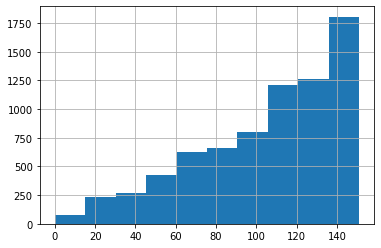

In [8]:
print('max tweet len:',text.map(len).max())
print('min tweet len:',text.map(len).min())
text.map(len).hist();

In [9]:
# over 60 chars
text = text[text.map(len)>60]
len(text)

6366

Obtener Diccionario Chars

In [10]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 78


In [11]:
chars

[' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 'ʉ',
 '̱',
 'ω',
 'я',
 'ӕ',
 'ԍ',
 'ԏ',
 'ԡ',
 'լ',
 'ջ',
 'ُ',
 '٪',
 '\u06dd',
 'ۢ',
 '۪']

Parece que los últimos pueden ser emojis, se observan frases con estos caracteres

In [12]:
for c in chars[-19:]:
    print('\nCHAR:', c)
    smple = [x for x in text if c in x]
    print(random.sample(smple,min(3,len(smple))))


CHAR: {
['"{crooked hillary clinton} created this mess, and she knows it." #draintheswamp']

CHAR: |
['join me in florida tomorrow! #makeamericagreatagain daytona | 3pm- jacksonville | 7pm-', 'rt @clewandowski_: trump winning over latino republicans, poll says | new york post', '"@politico: palin on 2016: "i think it would come down to cruz and trump! | getty']

CHAR: }
['"{crooked hillary clinton} created this mess, and she knows it." #draintheswamp']

CHAR: ~
['rt @danscavino: join @realdonaldtrump on his official social media platforms during tonights debate ~ as @teamtrump manages rapid response_', '"@judgemoroz zogby is respected in the business of polling ~ the media is attempting to silence the message @realdonaldtrump"', '"@freestateyank: "the only way anybodys gonna beat trump is being better than he is."~@rushlimbaugh on @realdonaldtrump."']

CHAR: ʉ
['my pro-growth econ plan: eliminate excessive regulations! lean government! lower taxes! #debatesʉ_']

CHAR: ̱
['mexico has l

Se eliminan estos al no tener una conclusión clara.


In [13]:
import re
for c in chars[-19:]:
    text = text.str.replace(c,'')

In [14]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

chars


total chars: 59


[' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

## Input data

In [15]:
maxlen = 40
step = 1
sentences = []
next_chars = []
for x in text:
    for i in range(0, len(x) - maxlen, step):
        sentences.append(x[i: i + maxlen])
        next_chars.append(x[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 472774


In [16]:
## example
for i in range(3):
    print(sentences[i],'==>',next_chars[i])

today we express our deepest gratitude t ==> o
oday we express our deepest gratitude to ==>  
day we express our deepest gratitude to  ==> a


In [17]:
text[0]

'today we express our deepest gratitude to all those who have served in our armed forces. #thankavet'

## Vectorización

In [18]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


## Creación de modelo

In [19]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


## Muestreo

In [20]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

La temperatura ayuda a no tener el mismo texto generado cada vez
- baja temperatura = texto similar a los datos entrenados
- alta temperatura = generación más creativa
- temperatura demasiado alta = tonterías.

In [21]:
for temperature in [0.1, 0.2, 0.3,  0.5, 1.0, 1.2, 1.3]:
    print(sample([.1,.3,.5,.1],temperature=temperature))

2
2
2
2
1
2
2


# Generar Tweets


In [22]:
def on_epoch_end(epoch, _):
    print()
    print('Generating text after Epoch: %d' % epoch)
    
    tweet = np.random.choice(text) 
    start_index = 0

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = tweet[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(120):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [23]:
x_train = x[:50000]
y_train = y[:50000]

In [24]:
epochs = 30

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/30
472774/472774 [==============================] - 156s 329us/step - loss: 2.3242

Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "the seriously failing @nytimes, despite "
the seriously failing @nytimes, despite the beal the will the poll be the will never a the bet will the poll the will the presidented the the will the reald and
----- diversity: 0.5
----- Generating with seed: "the seriously failing @nytimes, despite "
the seriously failing @nytimes, despite the deald to me is shan to in a peill and will bo of the bibing is the bebig a conther be how the voted for really a mid
----- diversity: 1.0
----- Generating with seed: "the seriously failing @nytimes, despite "
the seriously failing @nytimes, despite the.! cow the campactioned ness yon. todestord millan. vitting and speing! pagofing you! wis and ac siard resport thotis
----- diversity: 1.2
----- Generating with seed: "the seriously failing @nytimes, despite "
the seriously failing @nyt

wow, @cnn is really working hard to make america great again! #trump2016 #makeamericagreatagain #trump2016" #trump2016 #trump2016 #makeamericagreatagain #trump2
----- diversity: 0.5
----- Generating with seed: "wow, @cnn is really working hard to make"
wow, @cnn is really working hard to make america great again!" thanks! #makeamericagreatagain #trump2016 #makeamericagreatagain" thank you! #trump2016 #trump201
----- diversity: 1.0
----- Generating with seed: "wow, @cnn is really working hard to make"
wow, @cnn is really working hard to make america great again." /5.0. with me to get told hour prosperteak! take america great gaing and very new yiince to evay 
----- diversity: 1.2
----- Generating with seed: "wow, @cnn is really working hard to make"
wow, @cnn is really working hard to make america great again!_going make america great again." great! @reatenvestifundyc is siccisajor #ago! #makeamericagreatag
Epoch 9/30
472774/472774 [==============================] - 155s 328us/step - lo

"@vincentkunicki: @realdonaldtrump @kimgeincthinkey #trump2016 #fitn #makeamericagreatagain" thanks report for trump is on the presidential and bad failing was 
----- diversity: 1.0
----- Generating with seed: ""@vincentkunicki: @realdonaldtrump @kimg"
"@vincentkunicki: @realdonaldtrump @kimgroycalloin now at 8:00 surman susper themptorc!" i will be bacpborders #gopdebate. you are invevering the mouth. i have 
----- diversity: 1.2
----- Generating with seed: ""@vincentkunicki: @realdonaldtrump @kimg"
"@vincentkunicki: @realdonaldtrump @kimgrighhachiin conjustited nw at trump, we revotening...stending out &amp; al elect anything. at 22 minttins and like this 
Epoch 16/30
472774/472774 [==============================] - 158s 335us/step - loss: 1.3576

Generating text after Epoch: 15
----- diversity: 0.2
----- Generating with seed: ""@currentlyfeed: the #cnbcgopdebate poll"
"@currentlyfeed: the #cnbcgopdebate poll the people in the supporters that we doesnt have been a great and the world

bernie sanders is continuing his quest because of fantastic? #trump2016" dauld." cwaring. saturday. i hope over ranshom!" they are make america great again! #tr
----- diversity: 1.2
----- Generating with seed: "bernie sanders is continuing his quest b"
bernie sanders is continuing his quest back fairly. all our vetial. whats that at this dumbeonist! #makeamericagreatagain #following @realdonaldtrump lind. we a
Epoch 23/30
472774/472774 [==============================] - 152s 322us/step - loss: 1.3192

Generating text after Epoch: 22
----- diversity: 0.2
----- Generating with seed: ""@herb_stamper: @jackoffjosh711 @senfran"
"@herb_stamper: @jackoffjosh711 @senfranthestition @cnn @cnn @realdonaldtrump thank you for the people of the great statements and the debate to make america gr
----- diversity: 0.5
----- Generating with seed: ""@herb_stamper: @jackoffjosh711 @senfran"
"@herb_stamper: @jackoffjosh711 @senfranthinary @megynkelly and and the only one of voting for you and all respect t

the @abc poll sample is heavy on democrats?" many polls, i whe overear ads into virginia! of not me% wiving) ailist:!!" #beast. hid was he is do negotiate down 
Epoch 30/30
472774/472774 [==============================] - 159s 336us/step - loss: 1.2939

Generating text after Epoch: 29
----- diversity: 0.2
----- Generating with seed: "ready to lead. ready to make america gre"
ready to lead. ready to make america great again! #trump2016 #makeamericagreatagain #trump2016 #makeamericagreatagain! thank you! #trump2016 #makeamericagreatag
----- diversity: 0.5
----- Generating with seed: "ready to lead. ready to make america gre"
ready to lead. ready to make america great again!" thanks. #cruz many things about trump for crooked hillary care of the money. big crowds and deforted the word
----- diversity: 1.0
----- Generating with seed: "ready to lead. ready to make america gre"
ready to lead. ready to make america great again!! "their @neowa dhy ruin fast). just dumb are (making terrorist lea

## Prueba de texto


In [25]:
def generate_w_seed(sentence,diversity):
    sentence = sentence[0:maxlen]
    print(f'seed: {sentence}')
    print(f'diversity: {diversity}')
    generated = ''
    generated += sentence
    
    sys.stdout.write(generated)

    for i in range(120):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    return

In [26]:
for s in random.sample(list(text),5):
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        generate_w_seed(s,diversity)
        print()


seed: "@longbyfive: @realdonaldtrump great int
diversity: 0.2
"@longbyfive: @realdonaldtrump great interview in the presidential polls on the family and a great people of the presidential politicians and she will be the on

seed: "@longbyfive: @realdonaldtrump great int
diversity: 0.5
"@longbyfive: @realdonaldtrump great interview rost on the #trumptrain i am the most time to all to fire me to the debates everyone and energy of the presidenti

seed: "@longbyfive: @realdonaldtrump great int
diversity: 1.0
"@longbyfive: @realdonaldtrump great interview is a naber of the polls - the republican pircy horrible thurdifle to very publiche people. he should never be the

seed: "@longbyfive: @realdonaldtrump great int
diversity: 1.2
"@longbyfive: @realdonaldtrump great interview youre..." i will be bring politicians to vote for allowica, incredible!! kasich should do you wonll gone have!" a

seed: and finally, cruz strongly told thousand
diversity: 0.2
and finally, cruz strongly told thousands 

In [27]:
model.save("model_01")